<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/Kareem_mohamed_%5B202200402%5D_DSAI305_Project_EDA_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install kagglehub pandas numpy scikit-learn seaborn matplotlib

## 1. Data Loading and Initial Inspection
We start by downloading the dataset using `kagglehub`
https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv?select=loan.csv
 and loading it into a pandas DataFrame. The dataset contains loan records with features like loan amount, interest rate, and borrower details.

In [ ]:
import kagglehub
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Download dataset
path = kagglehub.dataset_download("adarshsng/lending-club-loan-data-csv")
print("Path to dataset files:", path)

# List all files in the downloaded path
print("Files:", os.listdir(path))

# Find the CSV file
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_path = os.path.join(path, file)
        break

# Load and process the CSV
df = pd.read_csv(csv_path, low_memory=False)

# First filter by loan status, then sample
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
random_seed = 42
df = df.sample(n=min(50000, len(df)), random_state=random_seed)
print("Shape after filtering and sampling:", df.shape)
df.head()

Path to dataset files: /kaggle/input/lending-club-loan-data-csv
Files: ['loan.csv', 'LCDataDictionary.xlsx']
Shape after filtering and sampling: (50000, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1749118,NaN,NaN,10000,10000,10000.00000,36 months,15.88,350.98,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2052155,NaN,NaN,3600,3600,3600.00000,36 months,11.99,119.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2134683,NaN,NaN,16000,16000,15826.02935,36 months,12.87,538.14,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
586707,NaN,NaN,6800,6800,6800.00000,36 months,12.79,228.44,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
555066,NaN,NaN,5075,5075,5075.00000,36 months,23.99,199.09,E,E2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


**Observations**:
- The dataset has 2,260,701 rows and 145 columns.
- The dataset after downsampling 50,000 rows and 145 columns.
- Columns like `id`, `member_id` are fully `NaN` in the sample, suggesting they may be irrelevant.
- We received a `DtypeWarning` earlier, indicating mixed types in some columns. Setting `low_memory=False` resolved it temporarily, but we'll inspect data types next.

1.1 Inspect Missing Values and Data Types:

The code converts numerical columns to float32 and categorical columns to category dtypes to optimize memory usage, and then calculates and displays the percentage of missing values for each column, showing the top 20 columns with the most missing data.

In [ ]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df[col] = pd.to_numeric(df[col], downcast='float')
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].astype('category')
# Check data types and missing values
print("Data Types and Missing Values:")
missing_info = pd.DataFrame({
    'Column': df.columns,
    'Missing %': df.isnull().mean() * 100,
    'Dtype': df.dtypes
})
display(missing_info.sort_values(by='Missing %', ascending=False).head(20))

Data Types and Missing Values:


,Column,Missing %,Dtype
id,id,100.000,float32
member_id,member_id,100.000,float32
url,url,100.000,float32
next_pymnt_d,next_pymnt_d,99.990,category
orig_projected_additional_accrued_interest,orig_projected_additional_accrued_interest,99.772,float32
sec_app_mths_since_last_major_derog,sec_app_mths_since_last_major_derog,99.630,float32
hardship_amount,hardship_amount,99.622,float32
hardship_start_date,hardship_start_date,99.622,category
hardship_end_date,hardship_end_date,99.622,category
hardship_payoff_balance_amount,hardship_payoff_balance_amount,99.622,float64


## 2. Data Preprocessing

Preprocessing involves handlind missing values, defining the target variable,encoding the target variable, dropping irrelevant columns, optimize memory usage, and address outliers . Our goal is to prepare a clean dataset for EDA and modeling.

In [ ]:
# Define post-default features to REMOVE (leak future information)
POST_DEFAULT_FEATURES = [
    # Payment behavior
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',

    # Post-approval status
    'last_pymnt_d_year', 'last_pymnt_d_month', 'last_credit_pull_d_year',
    'last_credit_pull_d_month',

    # Other derived features
    'installment_to_income'  # Uses payment data
]

2.1 Drop Irrelevant or High-Missing Columns

Columns with >50% missing values or and irrelevant features (e.g., `id`, `url`) are dropped to reduce dimensionality.

In [ ]:
# Drop columns with >50% missing values
high_missing = df.columns[df.isnull().mean() > 0.5]
if high_missing.size > 0:
    print(f"Dropping {len(high_missing)} columns with >50% missing values:", high_missing.tolist())
    df = df.drop(columns=high_missing)



# Drop additional irrelevant columns
irrelevant_cols = ['url', 'title', 'emp_title', 'zip_code', 'policy_code']
df = df.drop(columns=[col for col in irrelevant_cols if col in df.columns], errors='ignore')
print("Shape after dropping columns:", df.shape)

Dropping 58 columns with >50% missing values: ['id', 'member_id', 'url', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd

**Observation**:
- 44 columns have >50% missing values, including `id`, `member_id`,... which are likely irrelevant or incomplete.

2.2 Define Target Variable

The `loan_status` column is our target. We map it to a binary variable: 0 for "Fully Paid" and 1 for "Charged Off" or "Default." Other statuses (e.g., "Current") are ambiguous and excluded.

In [ ]:
# Inspect loan_status values
print("Loan Status Distribution:")
print(df['loan_status'].value_counts())

# Define target: 0 = Fully Paid, 1 = Default/Charged Off
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
df['target'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1, 'Default': 1})
print("\nShape after filtering loan_status:", df.shape)
print("Target Distribution:")
print(df['target'].value_counts(normalize=True))

Loan Status Distribution:
loan_status
Fully Paid     39884
Charged Off    10111
Default            5
Name: count, dtype: int64

Shape after filtering loan_status: (50000, 84)
Target Distribution:
target
0    0.79768
1    0.20232
Name: proportion, dtype: float64


**Insight**:
- The target is imbalanced (~80% non-default vs. 20% default), which we'll address in modeling.

In [ ]:
print(list(df.columns))

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever

In [ ]:
# 3. Remove post-default features
post_default_in_data = [f for f in POST_DEFAULT_FEATURES if f in df.columns]
if post_default_in_data:
    print(f"Removing {len(post_default_in_data)} post-default features")
    df = df.drop(columns=post_default_in_data)

Removing 10 post-default features


2.3 Handle Missing Values
For remaining columns:
- Numerical: Impute with median (robust to outliers).
- Categorical: Impute with mode or a placeholder ("Unknown").

In [ ]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['float32']).columns.drop('target', errors='ignore')
cat_cols = df.select_dtypes(include=['category']).columns

# Impute numerical columns with median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Impute categorical columns with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    print(f"Imputed {col} with mode: {df[col].mode()[0]}")

print("Missing values after imputation:", df.isnull().sum().sum())

Imputed term with mode:  36 months
Imputed grade with mode: B
Imputed sub_grade with mode: C1
Imputed emp_length with mode: 10+ years
Imputed home_ownership with mode: MORTGAGE
Imputed verification_status with mode: Source Verified
Imputed issue_d with mode: Oct-2015
Imputed loan_status with mode: Fully Paid
Imputed pymnt_plan with mode: n
Imputed purpose with mode: debt_consolidation
Imputed addr_state with mode: CA
Imputed earliest_cr_line with mode: Aug-2001
Imputed initial_list_status with mode: w
Imputed last_pymnt_d with mode: Aug-2018
Imputed last_credit_pull_d with mode: Feb-2019
Imputed application_type with mode: Individual
Imputed hardship_flag with mode: N
Imputed disbursement_method with mode: Cash
Imputed debt_settlement_flag with mode: N
Missing values after imputation: 0


**Observation** :

- Impute missing values in numerical columns using the median and in categorical columns using the mode.
- The output confirms that all missing values across the DataFrame have been successfully filled, resulting in a dataset with no NaNs.

2.4 Handle Data Types and Outliers

We inspect numerical columns for outliers and convert date columns (e.g., `issue_d`) to datetime if needed.

In [ ]:
import numpy as np
# Cap outliers
def cap_outliers(series, multiplier=3.0):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - multiplier * iqr, q3 + multiplier * iqr
    return series.clip(lower, upper)


# 6. Feature engineering - ONLY pre-approval data
for col in ['annual_inc', 'loan_amnt', 'dti']:
    if col in df.columns:
        df[col] = cap_outliers(df[col])


# Process date columns
date_cols = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%b-%Y', errors='coerce')
        # Extract year and month
        df[f'{col}_year'] = df[col].dt.year.astype('int32')
        df[f'{col}_month'] = df[col].dt.month.astype('int32')
        df.drop(columns=[col], inplace=True)

    if 'earliest_cr_line' in df.columns:
        df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
        df['credit_history_years'] = (df['issue_d_year'] - df['earliest_cr_line'].dt.year).clip(lower=0)
        df = df.drop(columns=['earliest_cr_line'])



print("Data types after preprocessing:")
print(df.dtypes)
print("Final shape:", df.shape)

Data types after preprocessing:
loan_amnt                    float32
funded_amnt                  float32
funded_amnt_inv              float64
term                        category
int_rate                     float32
                              ...   
credit_history_years           int32
last_pymnt_d_year              int32
last_pymnt_d_month             int32
last_credit_pull_d_year        int32
last_credit_pull_d_month       int32
Length: 77, dtype: object
Final shape: (50000, 77)


**Observation** :

- Apply several preprocessing steps to the data, including log-transforming and capping outliers in 'annual_inc' and 'loan_amnt', capping outliers in 'dti', and converting date columns into numerical year and month features while dropping the original date columns.
- The final output shows the data types of the processed DataFrame and its resulting shape of (28876, 102).

2.5 Optimize Memory Usage


In [ ]:
print("Memory usage:", df.memory_usage(deep=True).sum() / 1e6, "MB")

Memory usage: 14.164058 MB


In [ ]:
import gc
gc.collect()

30208

#3. Save Preprocessed Data
We save the preprocessed dataset for use in EDA and modeling.

In [ ]:
# Save preprocessed data
df.to_csv('preprocessed_loan_data.csv', index=False)
print("Preprocessed data saved as 'preprocessed_loan_data.csv'")

Preprocessed data saved as 'preprocessed_loan_data.csv'


In [ ]:
import gc
gc.collect()

0

# 4- Exploratory Data Analysis (EDA)

We explore the dataset to understand feature distributions, relationships, and their impact on the target (`target`). This guides feature engineering and modeling.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

In [ ]:
# Define pre-approval numerical features (no payment behavior)
PRE_APPROVAL_NUM_FEATURES = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util',
    'fico_score', 'credit_history_years', 'loan_to_income'
]

# Define pre-approval categorical features
PRE_APPROVAL_CAT_FEATURES = [
    'grade', 'sub_grade', 'home_ownership', 'purpose',
    'verification_status', 'emp_length'
]

4.1 Target Variable Distribution

We visualize the proportion of defaults vs. non-defaults.

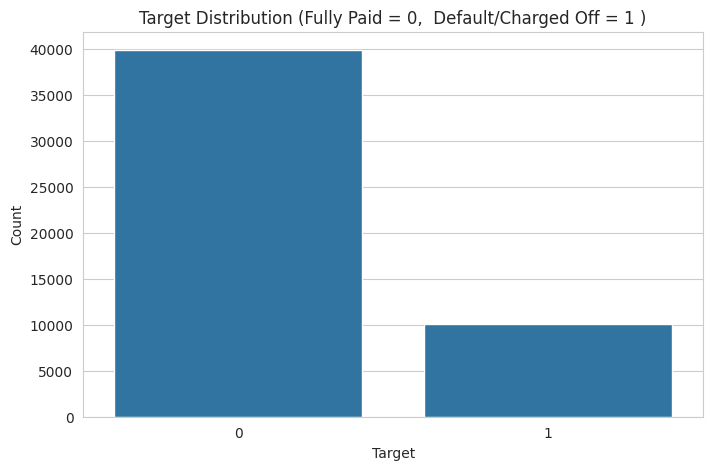

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df)
plt.title('Target Distribution (Fully Paid = 0,  Default/Charged Off = 1 )')
plt.xlabel('Target')
plt.ylabel('Count')
plt.savefig('target_distribution.png')
plt.show()

**Observation** :
- A bar plot visualizing the distribution of the target variable, where 0 represents "Fully Paid" loans and 1 represents "Default/Charged Off" loans.
- The plot shows a clear imbalance in the target variable, with a significantly higher number of fully paid loans compared to those that defaulted or were charged off.

4.2 Numerical Features

We examine key numerical features: `loan_amnt`, `int_rate`, `annual_inc`, and `dti`.

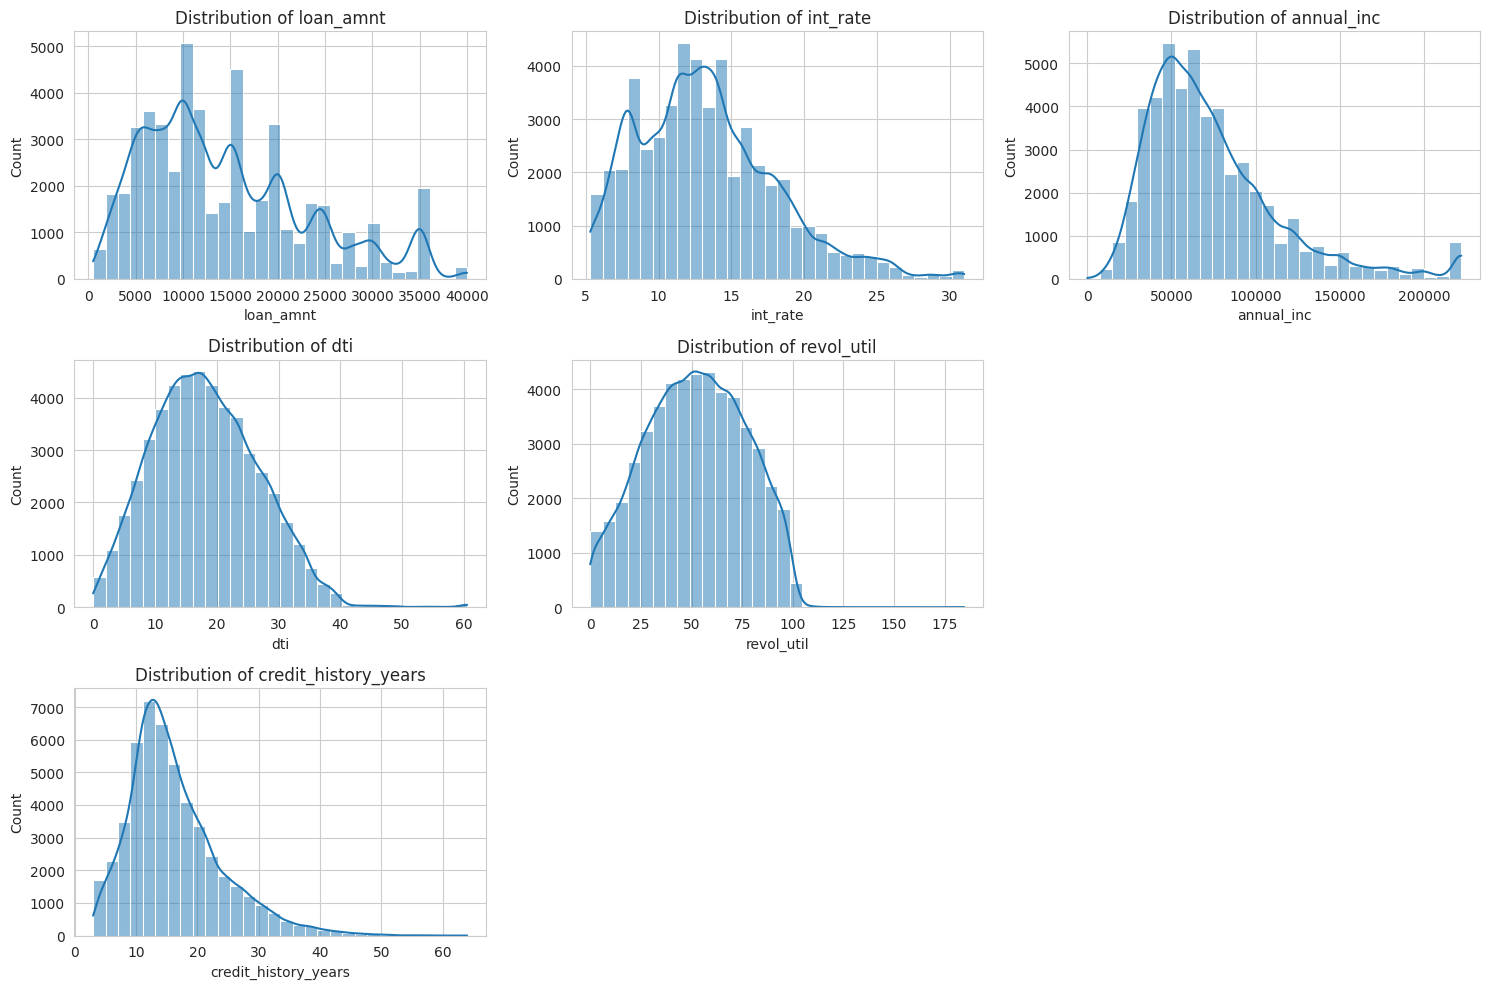

In [ ]:
# Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(PRE_APPROVAL_NUM_FEATURES, 1):
    if col in df.columns:
        plt.subplot(3, 3, i)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('numerical_distributions_pre_approval.png')
plt.show()

**Observation** :

-

-

4.3 Numerical Features vs. Target

We compare feature distributions across target classes.

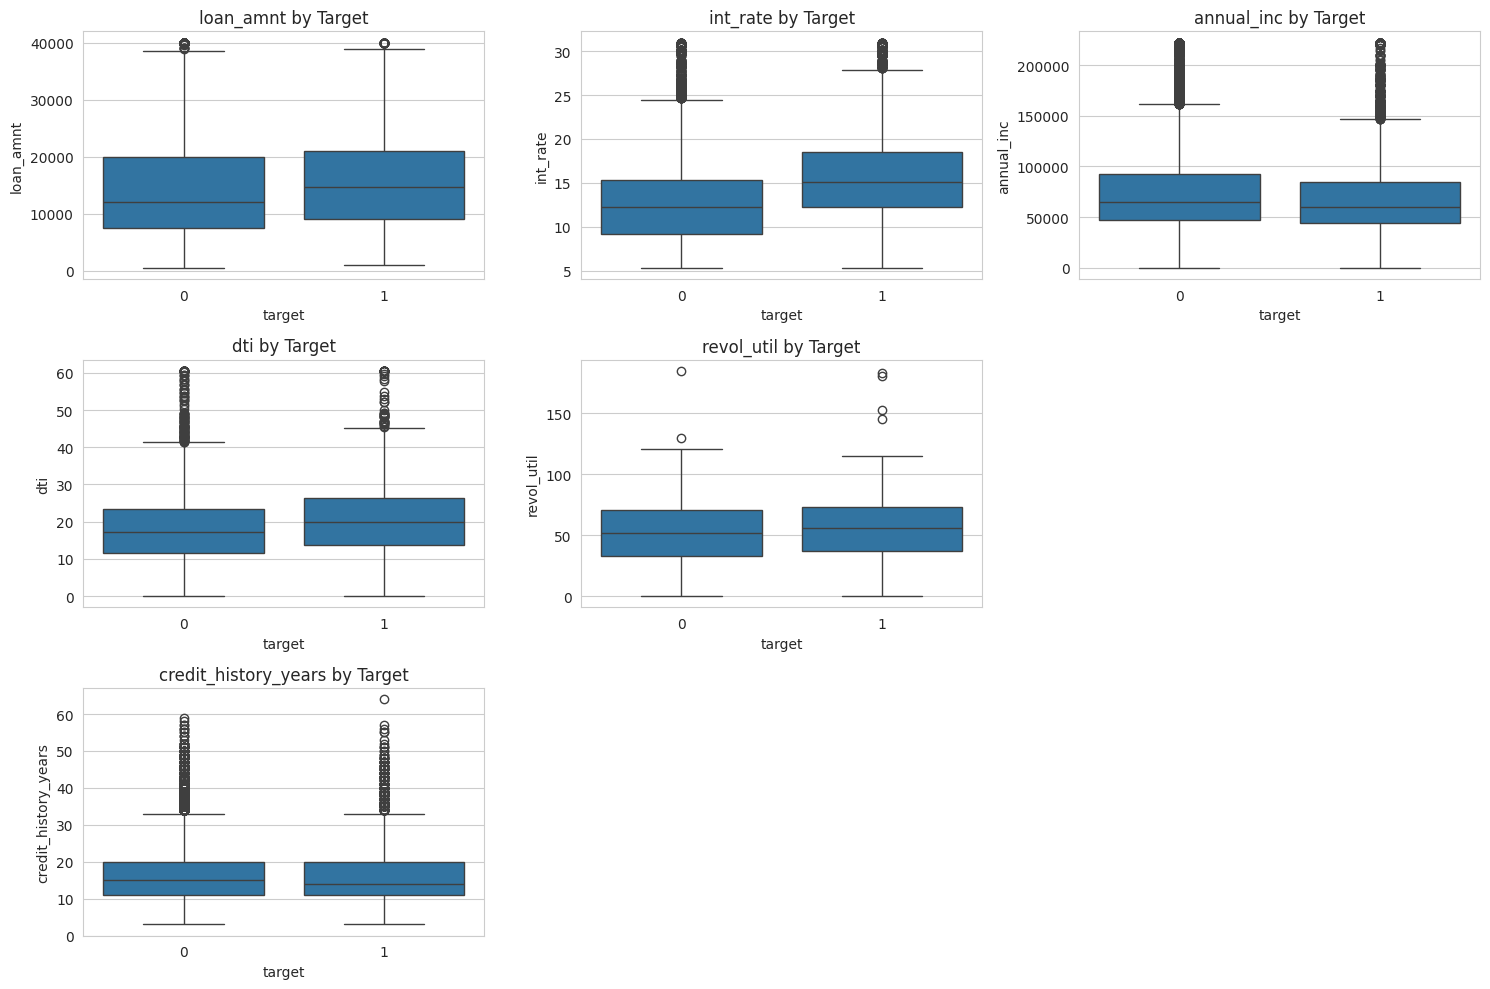

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(PRE_APPROVAL_NUM_FEATURES, 1):
    if col in df.columns:
        plt.subplot(3, 3, i)
        sns.boxplot(x='target', y=col, data=df)
        plt.title(f'{col} by Target')
plt.tight_layout()
plt.savefig('numerical_vs_target_pre_approval.png')
plt.show()

**Observation** :

-
-
-
-




4.4 Categorical Features

We analyze `grade`, `home_ownership`, and `purpose`.

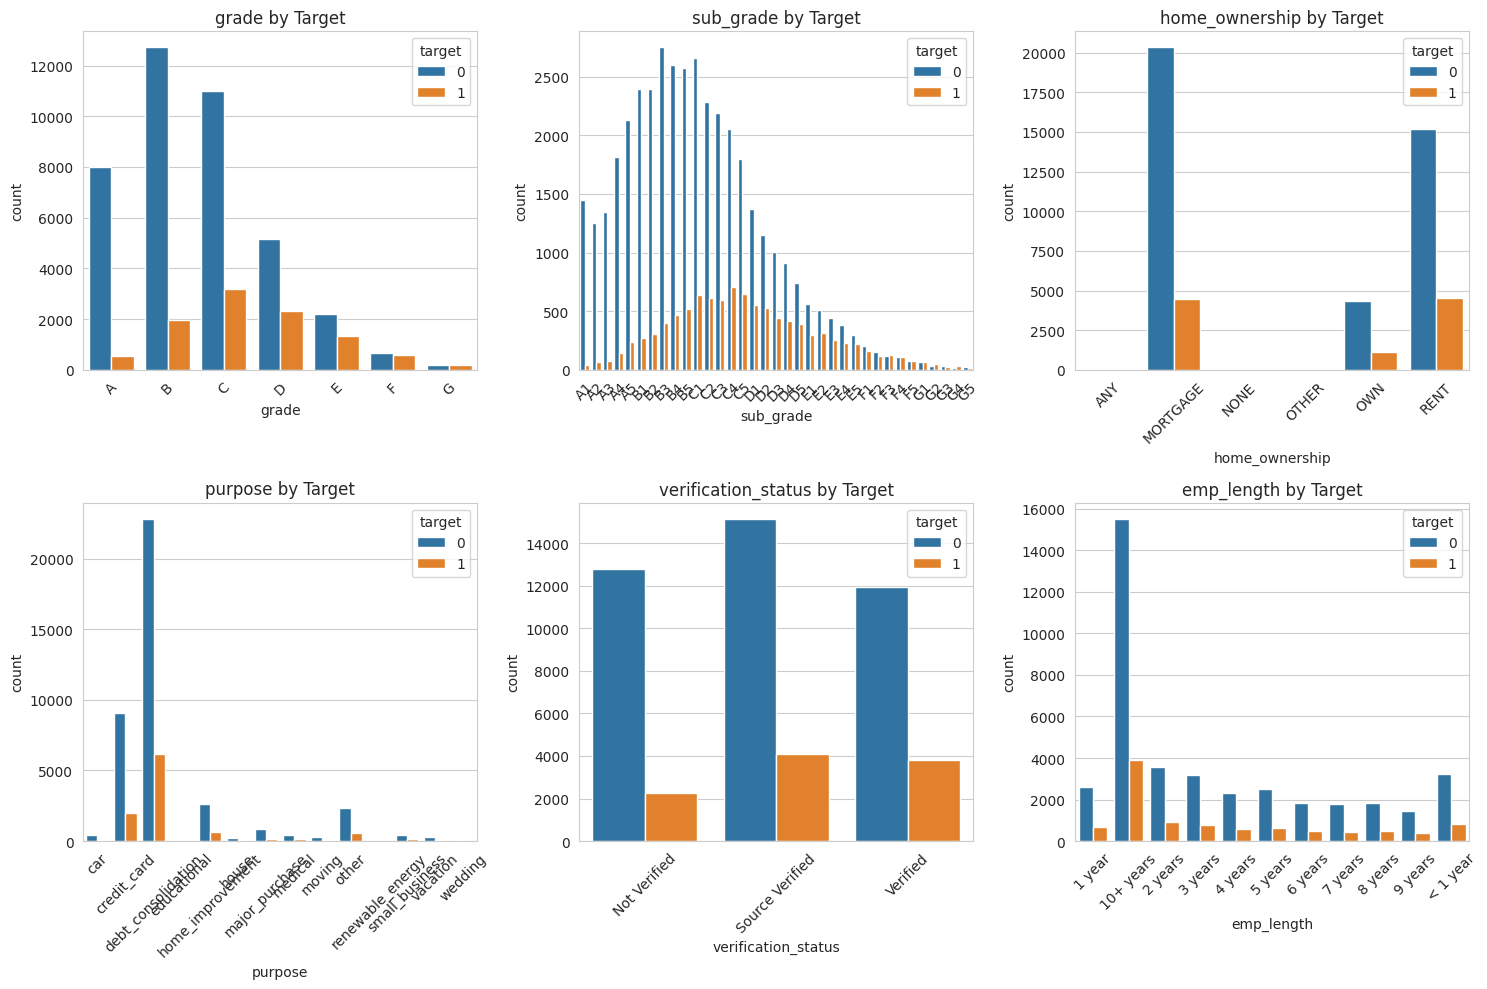

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(PRE_APPROVAL_CAT_FEATURES, 1):
    if col in df.columns:
        plt.subplot(2, 3, i)
        sns.countplot(x=col, hue='target', data=df)
        plt.title(f'{col} by Target')
        plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('categorical_vs_target_pre_approval.png')
plt.show()

**Observation** :

-

-
-
-


4.5 Correlation Analysis

We check correlations among numerical features to identify redundancy.

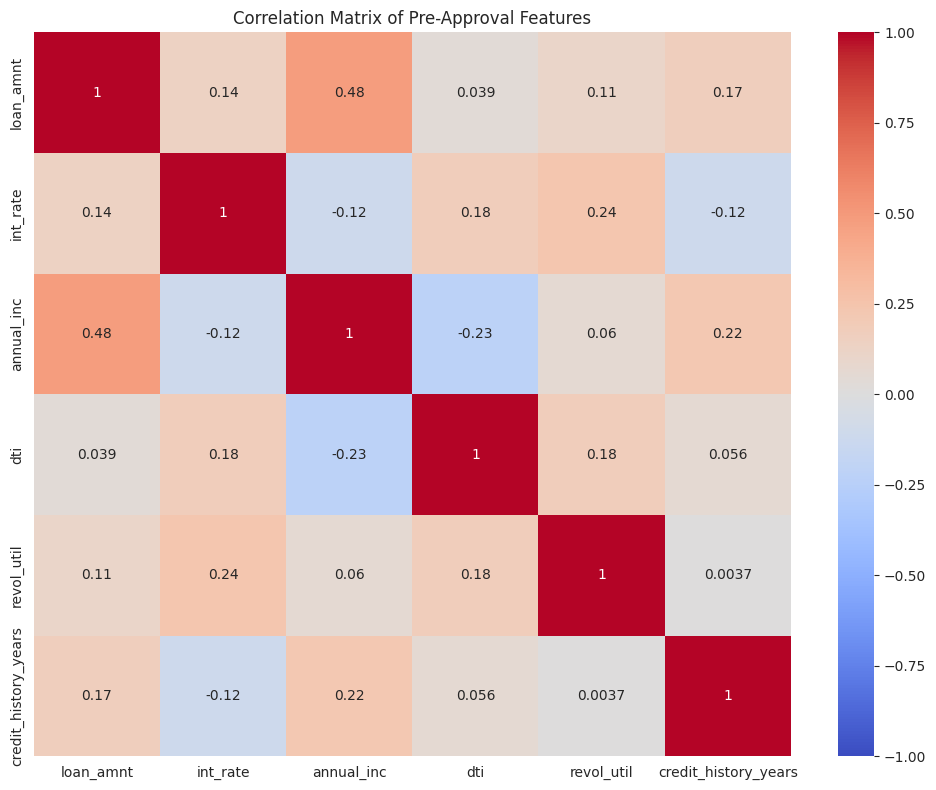

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))

# Get only the features that exist in the dataframe
available_features = [f for f in PRE_APPROVAL_NUM_FEATURES if f in df.columns]

if len(available_features) > 1:  # need at least 2 features for correlation
    corr = df[available_features].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Pre-Approval Features')
    plt.tight_layout()
    plt.savefig('correlation_matrix_pre_approval.png')
    plt.show()
else:
    print(f"Cannot compute correlation - only {len(available_features)} pre-approval numerical features available")
    print("Available features:", available_features)

**Observation** :

-
-
-
-


# 5- Feature Engineering / Feature Selection

We create new features, encode categorical variables, and apply feature selection using wrapper methods (Forward Selection and Recursive Feature Elimination) to prepare the dataset for modeling. We also check logistic regression assumptions to ensure model validity.

5.1 Feature Engineering

We’ll create new features to capture potential interactions and encode categorical variables for modeling.

In [ ]:
# 1. First, ensure proper date processing BEFORE feature engineering
def preprocess_dates(df):
    """Process all date columns and create derived features"""
    df = df.copy()

    # Process issue_d (loan issue date)
    if 'issue_d' in df.columns:
        df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
        df['issue_d_year'] = df['issue_d'].dt.year.astype('int16')
        df['issue_d_month'] = df['issue_d'].dt.month.astype('int8')
        df.drop(columns=['issue_d'], inplace=True)

    # Process earliest_cr_line (credit line start date)
    if 'earliest_cr_line' in df.columns:
        df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
        df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year.astype('int16')
        df.drop(columns=['earliest_cr_line'], inplace=True)

    return df

# Apply date preprocessing FIRST
df = preprocess_dates(df)

In [ ]:
# 2. Then modify your feature engineering function
def safe_feature_engineering(df):
    df = df.copy()

    # 1. Create credit history years (MUST be first operation)
    if 'issue_d_year' in df.columns and 'earliest_cr_line_year' in df.columns:
        df['credit_history_years'] = (df['issue_d_year'] - df['earliest_cr_line_year']).clip(lower=0)
        df['credit_history_years'] = df['credit_history_years'].astype('float32')
        # Optionally keep or drop the earliest_cr_line_year
        df.drop(columns=['earliest_cr_line_year'], inplace=True)

    # Rest of your existing feature engineering...
    if 'annual_inc' in df.columns and 'loan_amnt' in df.columns:
        df['loan_to_income'] = df['loan_amnt'] / df['annual_inc'].clip(lower=1000)
        df['loan_to_income'] = df['loan_to_income'].clip(upper=1.0)

    if 'dti' in df.columns:
        df['dti_ratio'] = df['dti'] / 100
        df['dti_ratio'] = df['dti_ratio'].fillna(df['dti_ratio'].median())


    if 'earliest_cr_line_year' in df.columns and 'issue_d_year' in df.columns:
        df['credit_history_years'] = (df['issue_d_year'] - df['earliest_cr_line_year']).clip(lower=0)

    if 'purpose' in df.columns:
        top_purposes = df['purpose'].value_counts().index[:5]
        df['purpose'] = df['purpose'].where(df['purpose'].isin(top_purposes), 'other')

    grade_mapping = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
    if 'grade' in df.columns:
        df['grade'] = df['grade'].astype(str).str.upper().fillna('C')
        df['grade'] = df['grade'].map(grade_mapping).astype('int32')

    if 'sub_grade' in df.columns:
        df['sub_grade'] = df['sub_grade'].astype(str).str.upper().str.strip()
        sub_grade_mapping = {f'{g}{i}': grade_mapping[g] + (i-1)*0.1
                            for g in grade_mapping.keys() for i in range(1,6)}
        df['sub_grade'] = df['sub_grade'].map(sub_grade_mapping).astype('float32')
        df['sub_grade'] = df['sub_grade'].fillna(df['grade'])

    # Get categorical columns before one-hot encoding
    cat_cols = [col for col in df.select_dtypes(include=['object', 'category'])
               if col not in ['grade', 'sub_grade']]

    # Downcast numeric columns first to save memory
    for col in df.select_dtypes(include=['float64']):
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']):
        df[col] = df[col].astype('int32')

    # One-hot encode (this creates new columns)
    if cat_cols:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    if df.isnull().sum().sum() > 0:
        raise ValueError("NaN values present after feature engineering")

    # Ensure credit_history_years is properly typed
    if 'credit_history_years' in df.columns:
        df['credit_history_years'] = df['credit_history_years'].astype('float32')

    return df


In [ ]:
# 3. EXECUTE the pipeline in correct order
# Step 1: Preprocess dates FIRST
print("Processing dates...")
df = preprocess_dates(df)

Processing dates...


In [ ]:
# Verify date features were created
print("\nAfter date processing - checking time features:")
print([col for col in df.columns if 'issue_d' in col or 'earliest_cr_line' in col])


After date processing - checking time features:
['issue_d_year', 'issue_d_month']


In [ ]:
# Step 2: Feature engineering
print("\nRunning feature engineering...")
df_engineered = safe_feature_engineering(df)


Running feature engineering...


In [ ]:
# 4. STRICT VERIFICATION
print("\n=== FINAL FEATURE VERIFICATION ===")
required_features = ['issue_d_year', 'issue_d_month', 'credit_history_years']
missing = [f for f in required_features if f not in df_engineered.columns]

if missing:
    raise ValueError(f"CRITICAL ERROR: Missing required time features: {missing}")
else:
    print("SUCCESS: All required time features present")
    print(df_engineered[required_features].head())


=== FINAL FEATURE VERIFICATION ===
SUCCESS: All required time features present
         issue_d_year  issue_d_month  credit_history_years
1749118          2013              7                  13.0
2052155          2014              3                  25.0
2134683          2009              9                  13.0
586707           2016              7                  19.0
555066           2016              8                  39.0


In [ ]:
# First, define which features to KEEP (only pre-approval features)

# 5. Ensure features are in PRE_APPROVAL_FEATURES
print("\nChecking feature inclusion in modeling features:")

PRE_APPROVAL_FEATURES = [
    # Loan characteristics
    'loan_amnt', 'term', 'installment', 'int_rate', 'grade', 'sub_grade',

    # Borrower characteristics
    'annual_inc', 'emp_length', 'home_ownership', 'verification_status',
    'dti', 'purpose',

    # Credit history
    'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
    'revol_util', 'total_acc', 'earliest_cr_line_year', 'fico_score',

    # Engineered features (must use only pre-approval data)
    'loan_to_income', 'dti_ratio',


    # Time features (only approval time)
    'issue_d_year', 'issue_d_month', 'credit_history_years',


    # Target
    'target'
]


# 4. Keep only pre-approval features

available_features = [f for f in PRE_APPROVAL_FEATURES if f in df_engineered.columns]
print(f"{len(available_features)}/{len(PRE_APPROVAL_FEATURES)} pre-approval features available")


Checking feature inclusion in modeling features:
20/27 pre-approval features available


In [ ]:
df_engineered.to_pickle('engineered_loan_data_leakproof.pkl')
print("\nFinal shape:", df_engineered.shape)
print("Time features saved successfully!")


Final shape: (50000, 152)
Time features saved successfully!


**Observations**

-
-
-


5.2 Feature Selection Using Wrapper Methods

We’ll apply Forward Selection and Recursive Feature Elimination (RFE) to select the top 10 features.

In [ ]:
PROTECTED_TEMPORAL_FEATURES = ['issue_d_year', 'issue_d_month', 'credit_history_years']

In [ ]:
# 5.2 Feature Selection

from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import pandas as pd
import numpy as np
import gc


# Load our leakage-proof engineered data
df_engineered = pd.read_pickle('engineered_loan_data_leakproof.pkl')

# Define X and y - using only pre-approval features
X = df_engineered.drop(columns=['target'])
y = df_engineered['target']

# 1. Initial Feature Filtering
# Drop constant and near-constant features
constant_features = [col for col in X.columns if X[col].nunique(dropna=False) <= 1]
if constant_features:
    X = X.drop(columns=constant_features)
    print(f"Dropped {len(constant_features)} constant features.")




# 2. Feature Selection Methods
# First ensure we have enough samples
if len(X) > 10000:
    sample_size = 10000
else:
    sample_size = int(0.8 * len(X))

# Forward Selection (ANOVA F-value)
print("\nRunning Forward Feature Selection...")
fsf_selector = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
X_new_fsf = fsf_selector.fit_transform(X, y)
selected_fsf_features = X.columns[fsf_selector.get_support()].tolist()
print("Top 10 features by ANOVA F-value:", selected_fsf_features)

# Recursive Feature Elimination
print("\nRunning Recursive Feature Elimination...")
try:
    # Sample for computational efficiency
    X_sample, y_sample = resample(X, y, n_samples=sample_size,
                            stratify=y, random_state=42)
    # Use simpler logistic regression for stability
    log_reg = LogisticRegression(max_iter=500, solver='liblinear', penalty='l2', C=1.0)
    rfe_selector = RFE(log_reg, n_features_to_select=10)
    rfe_selector.fit(X_sample, y_sample)
    selected_rfe_features = X.columns[rfe_selector.support_].tolist()
    print("Top 10 features by RFE:", selected_rfe_features)

    # 1. First combine features
    selected_features = list(set(selected_fsf_features + selected_rfe_features))

    # 2. Remove leakage features
    leakage_features = set(selected_features) & set(POST_DEFAULT_FEATURES)
    if leakage_features:
        print(f"\nRemoving {len(leakage_features)} leakage features: {leakage_features}")
        selected_features = [f for f in selected_features if f not in leakage_features]


    # 3. Add protected temporal features
    missing_temporal = [f for f in PROTECTED_TEMPORAL_FEATURES
                       if f not in selected_features and f in X.columns]
    if missing_temporal:
        print(f"Adding protected temporal features: {missing_temporal}")
        selected_features.extend(missing_temporal)



     # 4. Deduplicate while preserving order
    selected_features = list(dict.fromkeys(selected_features))
    print("\nFinal selected features:", selected_features)



except Exception as e:
    selected_features = selected_fsf_features
    missing_temporal = [f for f in PROTECTED_TEMPORAL_FEATURES
                       if f not in selected_features and f in X.columns]
    if missing_temporal:
        selected_features.extend(missing_temporal)
    print(f"RFE failed, using ANOVA results + temporal features: {selected_features}")



print("\n=== FINAL FEATURE VERIFICATION ===")
print("All temporal features present:",
      all(f in selected_features for f in PROTECTED_TEMPORAL_FEATURES))
print("Selected features count:", len(selected_features))
print("Temporal features in selection:",
      [f for f in selected_features if f in PROTECTED_TEMPORAL_FEATURES])


# 3. Create Final Dataset
X_selected = X[selected_features]



# Combine with target
final_df = pd.concat([X_selected, y], axis=1)
final_df.to_csv('final_loan_data_leakproof.csv', index=False)
print("\nFinal dataset shape:", final_df.shape)
print("Saved to 'final_loan_data_leakproof.csv'")

# Clean up
del X, X_new_fsf, X_sample, y_sample
gc.collect()

Dropped 8 constant features.

Running Forward Feature Selection...
Top 10 features by ANOVA F-value: ['int_rate', 'grade', 'sub_grade', 'dti', 'last_credit_pull_d_year', 'loan_to_income', 'dti_ratio', 'term_ 60 months', 'loan_status_Fully Paid', 'debt_settlement_flag_Y']

Running Recursive Feature Elimination...
Top 10 features by RFE: ['issue_d_year', 'last_pymnt_d_year', 'loan_to_income', 'term_ 60 months', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'verification_status_Verified', 'loan_status_Fully Paid', 'addr_state_MI', 'debt_settlement_flag_Y']

Removing 2 leakage features: {'last_credit_pull_d_year', 'last_pymnt_d_year'}
Adding protected temporal features: ['issue_d_month', 'credit_history_years']

Final selected features: ['debt_settlement_flag_Y', 'dti_ratio', 'term_ 60 months', 'addr_state_MI', 'sub_grade', 'loan_status_Fully Paid', 'home_ownership_RENT', 'issue_d_year', 'int_rate', 'home_ownership_MORTGAGE', 'verification_status_Verified', 'dti', 'grade', 'loan_to_inc

51799

In [ ]:
# Add this verification after feature selection
assert {'issue_d_year', 'issue_d_month', 'credit_history_years'}.issubset(final_df.columns), \
       "Temporal features missing in final dataset!"
print("Temporal features in final dataset:",
      [f for f in final_df.columns if f in PROTECTED_TEMPORAL_FEATURES])

Temporal features in final dataset: ['issue_d_year', 'issue_d_month', 'credit_history_years']


**Observation** :
-
-
-
-

In [ ]:
# Save preprocessed data
df.to_csv('preprocessed_loan_data.csv', index=False)
df.to_pickle('processed_loan_data.pkl')

# Save engineered data
df_engineered.to_pickle('engineered_loan_data_leakproof.pkl')

# Save final selected features
final_df.to_csv('final_loan_data_leakproof.csv', index=False)

* `final_loan_data_leakproof.csv` - The main dataset with selected features

* `engineered_loan_data_leakproof.pkl` - Engineered features (if needed)

* `processed_loan_data.pkl` - Fully processed data (if needed)

#Random forst model


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# PDP & ICE
from sklearn.inspection import PartialDependenceDisplay

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
final_df = final_df.drop(columns=["loan_status_Fully Paid"])

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1749118 to 1804223
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   debt_settlement_flag_Y        50000 non-null  bool   
 1   dti_ratio                     50000 non-null  float32
 2   term_ 60 months               50000 non-null  bool   
 3   addr_state_MI                 50000 non-null  bool   
 4   sub_grade                     50000 non-null  float32
 5   home_ownership_RENT           50000 non-null  bool   
 6   issue_d_year                  50000 non-null  int32  
 7   int_rate                      50000 non-null  float32
 8   home_ownership_MORTGAGE       50000 non-null  bool   
 9   verification_status_Verified  50000 non-null  bool   
 10  dti                           50000 non-null  float32
 11  grade                         50000 non-null  int32  
 12  loan_to_income                50000 non-null  float32
 13

In [ ]:
X = final_df.drop(columns=['target'])
y = final_df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# pipeline with different classifiers
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# fitting the pipelines
pipeline_rf.fit(X_train, y_train)
# predictions
y_pred_rf = pipeline_rf.predict(X_test)

# performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)


Random Forest Accuracy: 0.8234


#Hyperparameter Tuning
Through this code we will use GridSearchCV and will print Best parameters can get Higher Performance

In [ ]:
# hyperparameter grids for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}


pipeline_rf_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5))
])

# cross-validation and hyperparameter tuning
pipeline_rf_cv.fit(X_train, y_train)

# best hyperparameters and predictions
y_pred_rf_cv = pipeline_rf_cv.predict(X_test)


accuracy_rf_cv = accuracy_score(y_test, y_pred_rf_cv)
print("Random Forest Accuracy (with CV):", accuracy_rf_cv)


best_params_rf = pipeline_rf_cv.named_steps['classifier'].best_params_
print("\nBest Hyperparameters for RandomForestClassifier:")
print(best_params_rf)

Random Forest Accuracy (with CV): 0.8278

Best Hyperparameters for RandomForestClassifier:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}


#Model Evaluation
When using pipelines, model evaluation remains consistent with traditional workflows. The key advantage of pipelines is the seamless integration of preprocessing and modeling steps, making the overall process cleaner and more modular.

In [ ]:
classification_rep = classification_report(y_test, y_pred_rf_cv)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      8023
           1       0.84      0.16      0.27      1977

    accuracy                           0.83     10000
   macro avg       0.83      0.58      0.59     10000
weighted avg       0.83      0.83      0.78     10000



##Compare Scores and Values

In [ ]:
pipeline_rf_cv.fit(X_train, y_train)


y_pred_train = pipeline_rf_cv.predict(X_train)


y_pred_test = pipeline_rf_cv.predict(X_test)


accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training Set Accuracy:", accuracy_train)


accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Set Accuracy:", accuracy_test)

Training Set Accuracy: 0.833625
Test Set Accuracy: 0.8278


In [ ]:
best_model = pipeline_rf_cv.named_steps['classifier'].best_estimator_

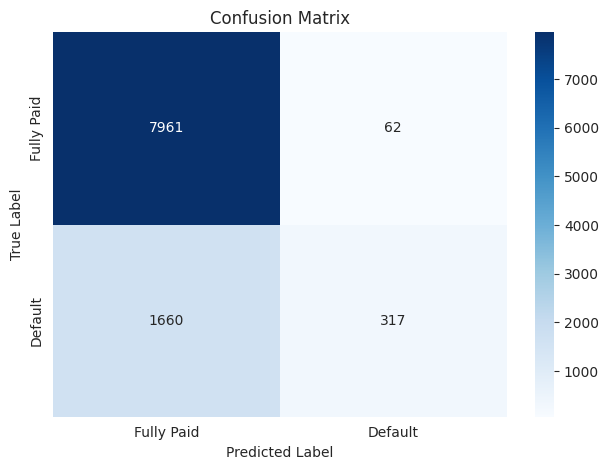

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_cv)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

## 🔍 Interpretation of Top Features (SHAP)

In [ ]:
# Extract scaler from the pipeline
scaler = pipeline_rf_cv.named_steps['scaler']

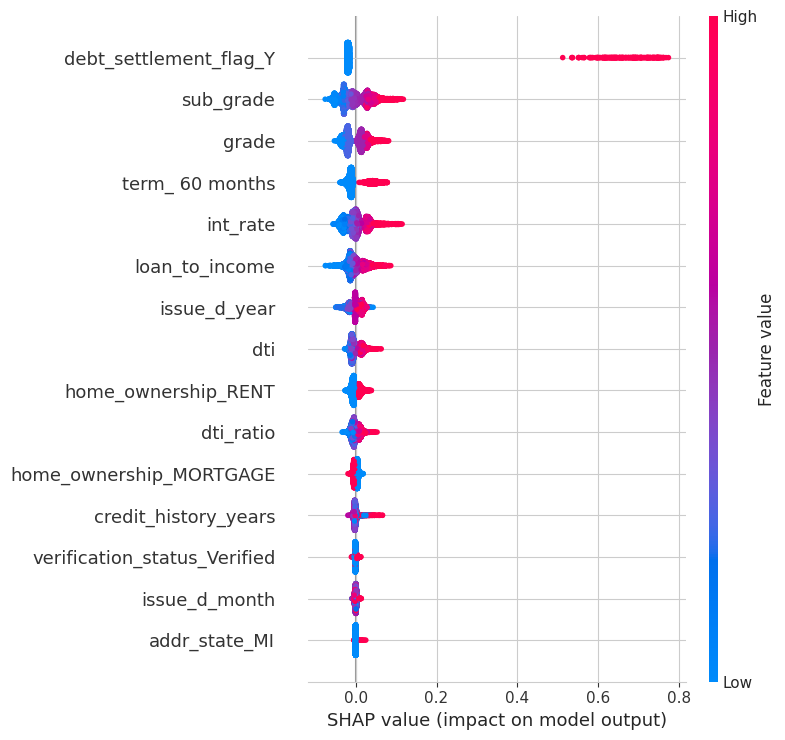

In [ ]:
# Transform data
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Get SHAP values from best_model (inside pipeline)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

shap_values = shap_values[:, :, 1]

# Now plot
shap.summary_plot(shap_values, X_test_scaled_df)

### 🔍 SHAP Summary Plot Interpretation

- **`debt_settlement_flag_Y`** has the highest influence. If it's `Y`, the model heavily leans toward predicting default.
- **`sub_grade`**, **`grade`**, and **`int_rate`** also play a critical role — higher values push predictions toward default.
- **`loan_to_income`**, **`dti_ratio`**, and **`term_60 months`** have noticeable yet moderate impact.
- SHAP helps visualize both global and local interpretability, ensuring transparency in feature influence.

#Permutation Feature Importance

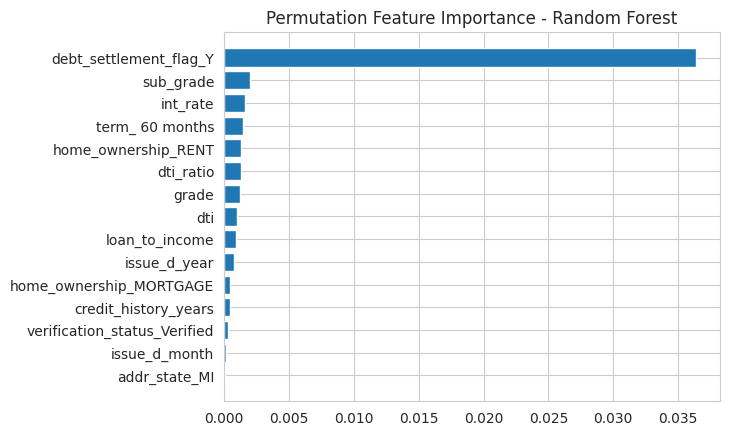

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipeline_rf_cv, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(final_df.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - Random Forest")
plt.show()

### 📊 Permutation Feature Importance Interpretation

- **`debt_settlement_flag_Y`** is the most impactful feature — when it's permuted, model performance drops significantly.
- **`sub_grade`** and **`int_rate`** come next, confirming SHAP importance.
- Features like **`term_60 months`** and **`loan_to_income`** have mid-level importance.
- This method validates feature importance through actual performance change, offering a robust ranking.

#**LOFO (Leave-One-Feature-Out Importance):**

#**Global Surrogate Model:**

#**Global Surrogate Model:**

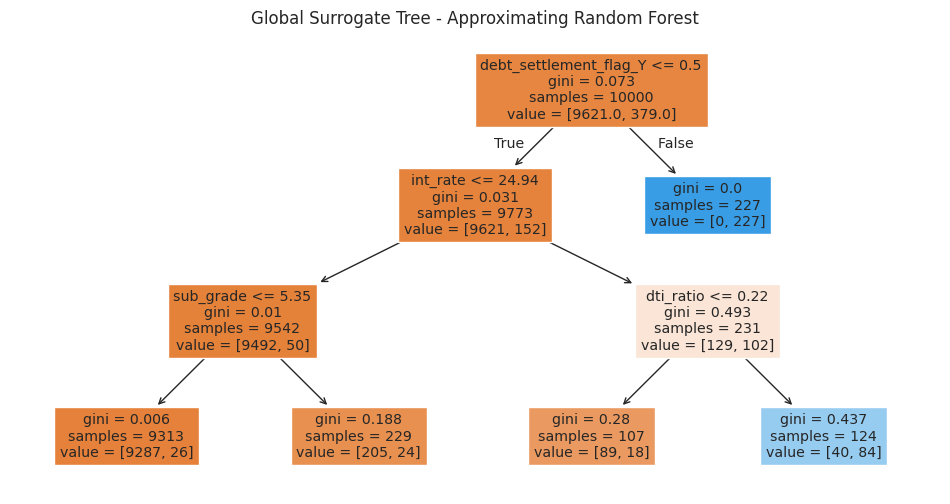

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# Train the surrogate on X_test and predictions from black-box model
surrogate = DecisionTreeClassifier(max_depth=3)
surrogate.fit(X_test, y_pred_rf_cv)

# Plot the surrogate tree
plt.figure(figsize=(12,6))
tree.plot_tree(surrogate, feature_names=X_test.columns, filled=True)
plt.title("Global Surrogate Tree - Approximating Random Forest")
plt.show()

### 🌲 Global Surrogate Tree Interpretation

- A shallow decision tree (max depth = 3) was trained to approximate the Random Forest's behavior.
- **Root Node**: Splits on `debt_settlement_flag_Y`, confirming it's the strongest signal.
- **Next Nodes**: Include `int_rate`, `sub_grade`, and `dti_ratio`.
- The surrogate offers a simple, human-readable summary of how the complex model behaves in most cases.

#**H-Statistic (Feature Interaction):**

The H-statistic defines the interaction between features as the share of variance that is explained by the interaction.


In [ ]:
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random

In [ ]:

X_exp = X.sample(n=100, random_state=8)
X_exp_scaled = scaler.transform(X_exp)
X_exp_scaled_df = pd.DataFrame(X_exp_scaled, columns=X.columns)

# Fit Friedman H statistic evaluator
h_stat = FriedmanHStatisticMethod()
h_stat.fit(pipeline_rf_cv, X_exp_scaled_df)

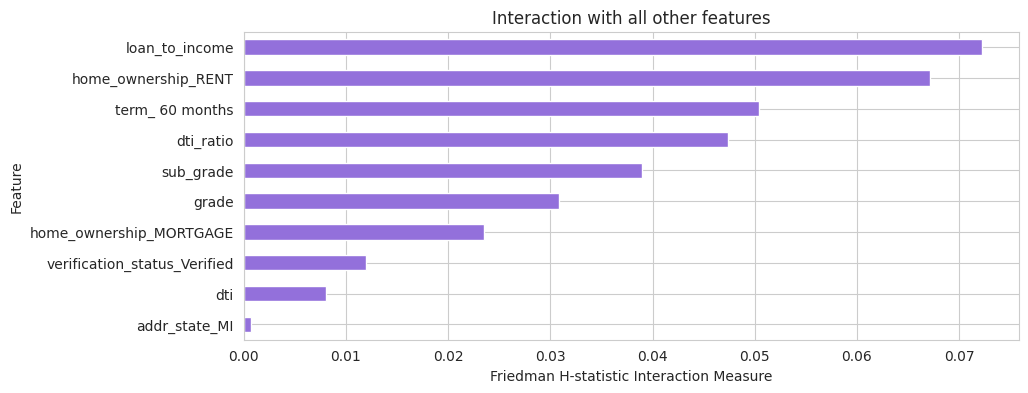

In [ ]:
# Overall interaction plot
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot('bar_chart_ova',ax=ax)

### 🔄 Feature Interaction Analysis (Friedman H-Statistic)

- **`loan_to_income`** shows the strongest interactions — its effect depends on other feature contexts.
- **`home_ownership_RENT`**, **`term_60 months`**, and **`dti_ratio`** are also moderately interacting.
- These insights reveal **nonlinear feature dependencies** and highlight where interactions are most critical.
- Helpful for simplifying models or engineering interaction terms in linear models.


# 📈 Partial Dependence Plot (PDP)

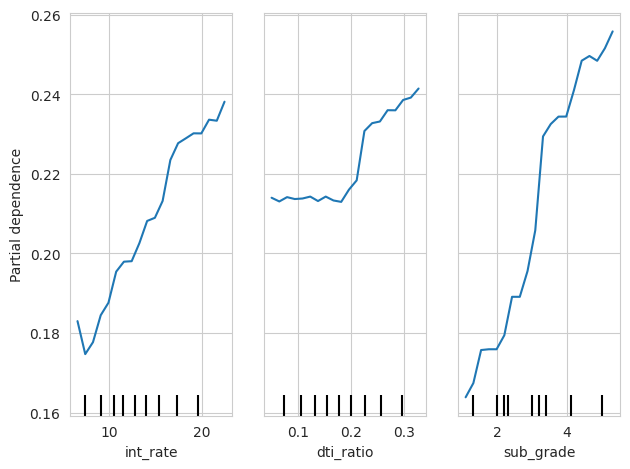

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
features_to_plot = ['debt_settlement_flag_Y', 'sub_grade', 'int_rate']

PartialDependenceDisplay.from_estimator(
    pipeline_rf_cv,
    X_test,
    features=['int_rate', 'dti_ratio','sub_grade'],
    grid_resolution=20
)
plt.tight_layout()
plt.show()

### 📈 Partial Dependence Plot (PDP) Interpretation

- **`int_rate`**: Higher rates significantly increase default risk.
- **`dti_ratio`**: A critical threshold around 0.2 exists — risk spikes above that.
- **`sub_grade`**: Lower grades (e.g., F/G) are associated with a steep increase in default probability.
- PDPs show the **average marginal effect** of each feature on the predicted outcome while keeping others constant.
